In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import math
import time
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
def rmse_estim(estimations, statistique_exacte):
    return math.sqrt(np.mean((estimations - statistique_exacte)**2))

In [5]:
def plot_fig_hf_vs_bf(n_samples, esp_mean_hf, std_mean_hf, rmse_mean_hf, esp_mean_bf, std_mean_bf, rmse_mean_bf, mu_exact, eq_cost=False):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
    eb_hf = axs[0].errorbar(
        n_samples, esp_mean_hf, std_mean_hf,
        fmt='x', color='gray', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Monte Carlo'
    )
    eb_bf = axs[0].errorbar(
        n_samples, esp_mean_bf, std_mean_bf,
        fmt='xb', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Control variate'
    )
    hl = axs[0].axhline(y=mu_exact, linestyle="--", dashes=(3, 3), linewidth=1, color="red", dash_capstyle="round")
    axs[0].set_xscale('log')
    axs[0].set_ylim([-20,100])
    axs[0].set_xlabel( ("budget" if eq_cost else "taille de l'échantillon") )
    axs[0].set_ylabel("estimateurs (moyenne ± ecart-type)")

    axs[1].plot(n_samples, rmse_mean_hf, 'o-', color='gray', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo HF')
    axs[1].plot(n_samples, rmse_mean_bf, 'ob-', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo BF')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel( ("budget" if eq_cost else "taille de l'échantillon") )
    axs[1].set_ylabel("REQM des estimateurs")
    axs[1].legend()

In [6]:
def plot_fig_cv(budgets, esp_mean_mc, std_mean_mc, rmse_mean_mc,  esp_mean_cv, std_mean_cv, rmse_mean_cv, mu_exact):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    eb_mc = axs[0].errorbar(
        budgets, esp_mean_mc, std_mean_mc,
        fmt='x', color='gray', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Monte Carlo'
    )
    eb_cv = axs[0].errorbar(
        budgets, esp_mean_cv, std_mean_cv,
        fmt='xb', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Control variate'
    )
    hl = axs[0].axhline(y=mu_exact, linestyle="--", dashes=(3, 3), linewidth=1, color="red", dash_capstyle="round")
    axs[0].set_xscale('log')
    axs[0].set_xlabel('budget')
    axs[0].set_ylabel("estimation de l'espérance")

    axs[1].plot(budgets, rmse_mean_mc, 'o-', color='gray', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo HF')
    axs[1].plot(budgets, rmse_mean_cv, 'ob-', lw=3, markeredgewidth=2, markersize=6, label='Control variate')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('budget')
    axs[1].set_ylabel('REQM des estimateurs')
    axs[1].legend()

In [7]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [8]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


In [9]:
# On considère le rapport w=1/35 théorique
w = 1/35
print(w)

0.02857142857142857


# Expérience pilote

In [10]:
p = 1000
X = n_echantillon_X(p)

Y = f(X)
Z = g(X)

In [11]:
cov_matrix_YZ = np.cov(Y, Z)
cov_YZ = cov_matrix_YZ[0,1]
var_Y = cov_matrix_YZ[0,0]
var_Z = cov_matrix_YZ[1,1]

In [12]:
alpha_opt = cov_YZ / var_Z
print(alpha_opt)

0.9970083009188742


In [13]:
rho2 = cov_YZ**2 / (var_Y * var_Z)
print(rho2)

0.9821677402992433


In [14]:
# Rapport de variance CV/MC à coût équivalent
beta_mu_Z_connue = (1 + w) * (1 - rho2)
print(beta_mu_Z_connue)

0.01834175283506408


# Estimateur multifidélité

In [15]:
# Nombre de répétitions et liste de budgets
nr = 10000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

## CV : espérance $\mu_Z$ connue

### Paramètre optimal $\alpha^*$ indépendant (précalculé avec les échantillons pilotes)

In [16]:
# mu_Z connue, alpha indep
esp_Y_cv_mean = []
std_Y_cv_mean = []
rmse_Y_cv_mean = []
esp_Y_mean = []
std_Y_mean = []
rmse_Y_mean = []

for n_tilde in budgets:
    Y_cv_mean = np.zeros(nr)
    Y_mean = np.zeros(nr)
    n = int( math.floor( n_tilde / (1. + w) ) )
    
    for ir in range(nr):
        X = n_echantillon_X(n_tilde)
        Y = f(X)
        Z = g(X)
        
        Y_mean_n_tilde = np.mean(Y)
        Y_mean_n = np.mean(Y[:n])
        Z_mean_n = np.mean(Z[:n])
        
        Y_mean[ir] = Y_mean_n_tilde
        Y_cv_mean[ir] = Y_mean_n - alpha_opt * (Z_mean_n - mu_Z_exact)

    esp_Y_mean += [np.mean(Y_mean)]
    std_Y_mean += [np.std(Y_mean)]
    rmse_Y_mean += [rmse_estim(Y_mean, mu_exact)]
    
    esp_Y_cv_mean += [np.mean(Y_cv_mean)]
    std_Y_cv_mean += [np.std(Y_cv_mean)] 
    rmse_Y_cv_mean += [rmse_estim(Y_cv_mean, mu_exact)]
    
    print(n_tilde, n,
        esp_Y_cv_mean[-1], esp_Y_mean[-1], rmse_Y_cv_mean[-1], rmse_Y_mean[-1], (std_Y_cv_mean[-1] / std_Y_mean[-1])**2 
    )

5 4 41.92141825019404 42.76971213767556 7.251061212614014 48.334022357924525 0.02251018505336329
10 9 41.9089893074012 41.97614502298261 4.852899799263292 33.83023289773042 0.02057252586448041
20 19 41.942872306191155 41.9972779419685 3.340943606463099 23.925724376919085 0.019495792110762272
50 48 41.93543107960387 41.79644261460285 2.1044628119461146 15.146316194694176 0.01929743125651125
100 97 41.89945714635778 42.00906450634188 1.4843870148964209 10.765717412755835 0.018948886920631486
200 194 41.90192101731768 41.77182709579681 1.060739836008251 7.554895367606283 0.019609508411650538
500 486 41.93432674625305 41.906780202715666 0.6534301999779358 4.762049807320331 0.01872237315926605
1000 972 41.9116489861909 41.96962832684615 0.4758436888351392 3.417329118913783 0.01893522470997189


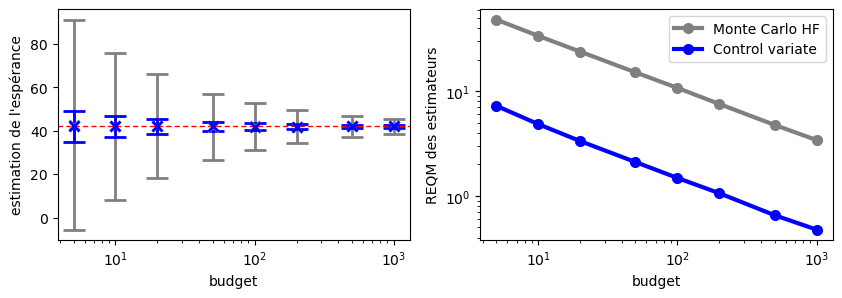

In [17]:
plot_fig_cv(budgets, esp_Y_mean, std_Y_mean, rmse_Y_mean, esp_Y_cv_mean, std_Y_cv_mean, rmse_Y_cv_mean, mu_exact)

### Paramètre optimal $\alpha^*$ estimé à la volée

In [18]:
# mu_Z connue, alpha à la volée
esp_Y_cv_mean = []
std_Y_cv_mean = []
rmse_Y_cv_mean = []
esp_Y_mean = []
std_Y_mean = []
rmse_Y_mean = []

for n_tilde in budgets:
    Y_cv_mean = np.zeros(nr)
    Y_mean = np.zeros(nr)
    n = int( math.floor( n_tilde / (1. + w) ) )
    
    for ir in range(nr):
        X = n_echantillon_X(n_tilde)
        Y = f(X)
        Z = g(X)
        
        Y_mean_n_tilde = np.mean(Y)
        Y_mean_n = np.mean(Y[:n])
        Z_mean_n = np.mean(Z[:n])
        
        cov_matrix_YZ = np.cov(Y[:n], Z[:n])
        cov_YZ = cov_matrix_YZ[0,1]
        var_Z = cov_matrix_YZ[1,1]
        
        alpha_opt_approx = cov_YZ / var_Z
        
        Y_mean[ir] = Y_mean_n_tilde
        Y_cv_mean[ir] = Y_mean_n - alpha_opt_approx * (Z_mean_n - mu_Z_exact)

    esp_Y_mean += [np.mean(Y_mean)]
    std_Y_mean += [np.std(Y_mean)]
    rmse_Y_mean += [rmse_estim(Y_mean, mu_exact)]
    
    esp_Y_cv_mean += [np.mean(Y_cv_mean)]
    std_Y_cv_mean += [np.std(Y_cv_mean)] 
    rmse_Y_cv_mean += [rmse_estim(Y_cv_mean, mu_exact)]
    
    print(n_tilde, n,
        esp_Y_cv_mean[-1], esp_Y_mean[-1], rmse_Y_cv_mean[-1], rmse_Y_mean[-1], (std_Y_cv_mean[-1] / std_Y_mean[-1])**2 
    )

5 4 42.58619935479205 41.91920372829997 16.22300054692912 47.62556562893828 0.11587373330723515
10 9 42.012480956927654 41.72612475090407 5.649084277944822 33.68631800285289 0.028123145120226824
20 19 41.959206221285406 42.01310752563741 3.551257967650166 24.01443626519661 0.021867457129965434
50 48 41.92891225081738 41.93013745986057 2.1734580718266465 15.052198131789176 0.02083648471727109
100 97 41.939683006559385 41.772005161488 1.4980227689439232 10.77041447978482 0.019335376234298235
200 194 41.905121163859995 41.8882027871515 1.0627821747165205 7.557267757758477 0.019669874007554163
500 486 41.92175335520545 41.9156338857874 0.6744124115216847 4.81299875305085 0.01946866156975446
1000 972 41.92123178207298 41.8598239360461 0.4719984070255972 3.3608911997536532 0.019395579116040496


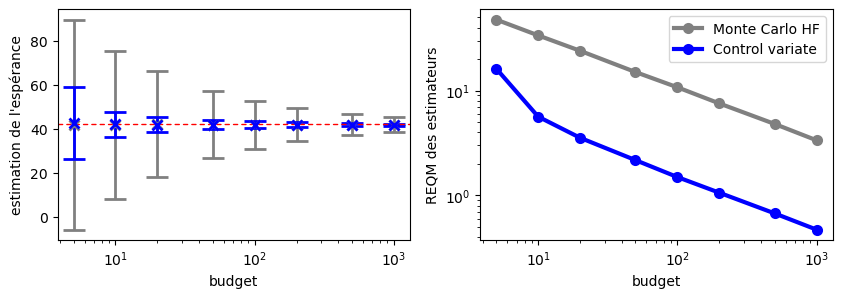

In [19]:
plot_fig_cv(budgets, esp_Y_mean, std_Y_mean, rmse_Y_mean, esp_Y_cv_mean, std_Y_cv_mean, rmse_Y_cv_mean, mu_exact)